# Cross-Lingual Automated Essay Scoring Project

## Abstract

**Cross-Lingual Automated Essay Scoring: Enhancing Hebrew Language Performance via Transfer Learning of an English Language Model.**

This notebook presents a cross-lingual automated essay scoring system that enhances the performance of Hebrew language essays using transfer learning from an English language model.

The code demonstrates the implementation of transfer learning techniques to fine-tune a pre-trained English language model, creating an accurate and robust scoring model for Hebrew essays. The process involves creating a new language model in English, training it on a large-scale dataset of English essays, and leveraging back translation to convert the dataset into Hebrew. Transfer learning is then applied to adapt the fine-tuned English model to the Hebrew dataset, enabling accurate scoring of Hebrew essays.

The code offers a practical and efficient solution for building cross-lingual automated essay scoring systems, benefiting educators, language learners, and NLP researchers.

\
**Author: Sharon Mordechai.**

## Automated Essay Scoring from English Language Data

This section introduces an automated approach for Cross-Lingual Automated Essay Scoring using English Language Data. The process is divided into clear steps to achieve the goal:

* **Exploratory Data Analysis (EDA)**: Before diving into the main analysis, we perform exploratory data analysis to gain insights into the dataset's characteristics.

* **Data Preprocessing**: Following the EDA, we prepare the data to ensure its consistency and quality. The text is cleaned by expanding contractions, making it easier to analyze.

* **BERT Embeddings**: Next, we convert the text into numerical embeddings using BERT, a powerful language model. This allows us to represent essays as meaningful vectors in a high-dimensional space.

* **Model Exploration**: We explore two types of models to find the best approach.
  * First, we try traditional machine learning models like Support Vector Classifier, Random Forest, Logistic Regression, and others.
  * Then, we delve into neural network models, beginning with fine-tuning the BERT Classifier. We also experiment with more complex architectures like LSTM, and CNN and explore the Attention mechanism.

* **Performance Comparison**: The ultimate goal is to compare the models and identify the most effective one for cross-lingual essay scoring. This comparison will offer valuable insights for researchers, educators, and NLP enthusiasts, enabling enhanced performance in automated essay-scoring tasks.

### Import Dependencies

Set up the environment with the essential dependencies.

In [ ]:
!pip install -q transformers sentencepiece contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.0 MB/s eta 0:00:00


In [ ]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import re
import contractions
import pickle
import time

from collections import Counter
from tqdm import tqdm
from tabulate import tabulate
from google.colab import files

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel
from transformers import BertModel, BertTokenizer
from transformers import MarianMTModel, MarianTokenizer
from transformers import BertForSequenceClassification

from gensim.models import Word2Vec, Phrases
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Initial device settings: cude/cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define random seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

### Dataset
The dataset used for this notebook code can be found at this [link](https://github.com/sharon12312/nlp-final-project-essay-scoring/blob/main/datasets/essay_scoring_dataset.tsv).

It is part of the [Kaggle competition](https://www.kaggle.com/competitions/asap-aes/overview) named "*The Hewlett Foundation: Automated Essay Scoring*" which focuses on developing an automated scoring algorithm for student-written essays.

In [ ]:
!wget https://raw.githubusercontent.com/sharon12312/nlp-final-project-essay-scoring/main/datasets/essay_scoring_dataset.tsv

--2023-08-12 07:06:08--  https://raw.githubusercontent.com/sharon12312/nlp-final-project-essay-scoring/main/datasets/essay_scoring_dataset.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16324188 (16M) [text/plain]
Saving to: ‘essay_scoring_dataset.tsv’

essay_scoring_datas 100%[===================>]  15.57M  --.-KB/s    in 0.05s   

2023-08-12 07:06:10 (299 MB/s) - ‘essay_scoring_dataset.tsv’ saved [16324188/16324188]



### Explore Data Analysis

Perform exploratory data analysis to gain insights into the dataset's characteristics.

#### Reading an Essay Scoring Dataset using Pandas

In [ ]:
df = pd.read_csv('essay_scoring_dataset.tsv', sep='\t', encoding='ISO-8859-1')

#### Percentage of Missing Values in DataFrame Columns

In [ ]:
df.isnull().sum() / df.shape[0] * 100.0

essay_id           0.000000
essay_set          0.000000
essay              0.000000
rater1_domain1     0.000000
rater2_domain1     0.000000
rater3_domain1    99.013564
domain1_score      0.000000
rater1_domain2    86.128237
rater2_domain2    86.128237
domain2_score     86.128237
rater1_trait1     82.336621
rater1_trait2     82.336621
rater1_trait3     82.336621
rater1_trait4     82.336621
rater1_trait5     94.428175
rater1_trait6     94.428175
rater2_trait1     82.336621
rater2_trait2     82.336621
rater2_trait3     82.336621
rater2_trait4     82.336621
rater2_trait5     94.428175
rater2_trait6     94.428175
rater3_trait1     99.013564
rater3_trait2     99.013564
rater3_trait3     99.013564
rater3_trait4     99.013564
rater3_trait5     99.013564
rater3_trait6     99.013564
dtype: float64

#### Drop Columns with Missing Values from DataFrame

In [ ]:
df.dropna(axis=1,inplace=True)

#### Analyzing Score Range for Each Essay Set

Description: This code snippet performs a grouped aggregation on a DataFrame to analyze the score range of each essay set, including minimum, maximum, count, and number of unique scores.

In [ ]:
df.groupby(['essay_set'])['domain1_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
essay_set,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


#### Normalizing Essay Scores within Each Essay Set

Description: This code snippet defines a normalization function to scale the 'domain1_score' values within each essay set to a range of 0 to 10 using the provided formula, and applies it to create a new column 'score' in the DataFrame for normalized scores.

In [ ]:
def normalize(x, min, max):
    return round((x - min) / (max - min) * 10)

# Initial range variables
min_range = df.groupby(['essay_set'])['domain1_score'].agg(['min'])['min'].to_numpy()
max_range = df.groupby(['essay_set'])['domain1_score'].agg(['max'])['max'].to_numpy()

df['score'] = df.apply(lambda x:normalize(x['domain1_score'], min_range[x['essay_set'] - 1], max_range[x['essay_set'] - 1]), axis=1)

#### DataFrame Information and Descriptive Statistics

In [ ]:
df.head(5)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,score
0,1,1,"Dear local newspaper, I think effects computer...",4,4,8,6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,8
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   essay_id        12976 non-null  int64 
 1   essay_set       12976 non-null  int64 
 2   essay           12976 non-null  object
 3   rater1_domain1  12976 non-null  int64 
 4   rater2_domain1  12976 non-null  int64 
 5   domain1_score   12976 non-null  int64 
 6   score           12976 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 709.8+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
essay_id,12976.0,10295.395808,6309.074105,1.0,4438.75,10044.5,15681.25,21633.0
essay_set,12976.0,4.179485,2.136913,1.0,2.00,4.0,6.00,8.0
rater1_domain1,12976.0,4.127158,4.212544,0.0,2.00,3.0,4.00,30.0
rater2_domain1,12976.0,4.137408,4.264330,0.0,2.00,3.0,4.00,30.0
domain1_score,12976.0,6.800247,8.970705,0.0,2.00,3.0,8.00,60.0
score,12976.0,5.924091,2.519079,0.0,4.00,6.0,8.00,10.0


#### <br>

#### Score Distribution Visualization

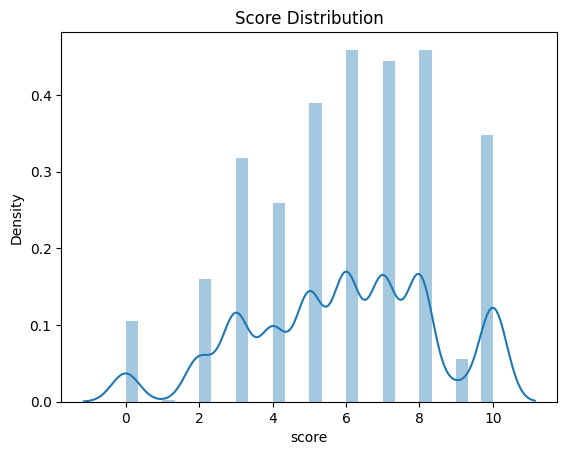

In [ ]:
sns.distplot(df['score'])
plt.title('Score Distribution')
plt.show()

#### Pie Chart: Distribution of Essay Scores

In [ ]:
# Distribution of sets of essay
labels = df['score'].value_counts().index
values = df['score'].value_counts().values
colors = df['score']

fig = go.Figure(data = [go.Pie(labels=labels, values=values, textinfo='label+percent', marker=dict(colors=colors, line=dict(color='#000000', width=2)))])
fig.show()

#### Max Essay Length vs. Score Bar Plot

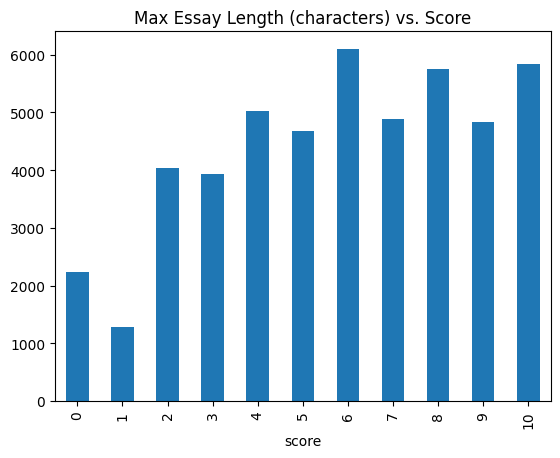

In [ ]:
df.groupby('score')['essay'].apply(lambda x: x.str.len().max()).plot.bar()
plt.title('Max Essay Length (characters) vs. Score')
plt.show()

#### Text Analysis and Word Cloud Generation

In [ ]:
# Helper Functions
def build_corpus(essays):
    words = [word.strip() for essay in essays for word in essay.split()]
    return words

def get_n_common_words(essays, n=10):
    return pd.Series(' '.join(essays).split()).value_counts().index.values[:n]

def get_n_uncommon_words(essays, n=10):
    return pd.Series(' '.join(essays).split()).value_counts().index.values[-n:]

def generate_word_cloud(corpus):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(corpus))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Initial corpus based on the essay dataset
corpus = build_corpus(df['essay'])

In [ ]:
print(f'10 common words in the corpus: {get_n_common_words(df["essay"], n=10)}')

10 common words in the corpus: ['the' 'to' 'and' 'a' 'of' 'that' 'I' 'in' 'is' 'was']


In [ ]:
print(f'10 unmommon words in the corpus: {get_n_uncommon_words(df["essay"], n=10)}')

10 unmommon words in the corpus: ['offenisive.' 'medicanes' 'percriptions' 'crank,' 'Advertisements,' 'ik'
 'invloved' 'Sinceraly,' 'tutouring,' 'expressionless']


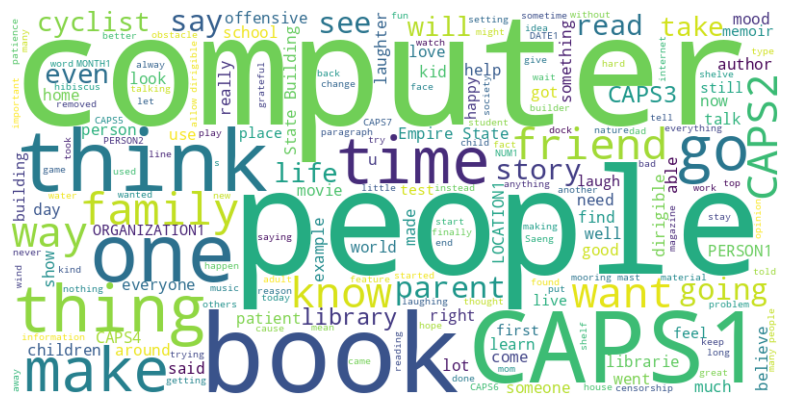

In [ ]:
generate_word_cloud(corpus)

### Data Preprocessing

Prepare the data to ensure its consistency and quality.

#### Cleaning Text Data: Expanding Contractions Function

In [ ]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

In [ ]:
def clean_text(text):
    text = expand_contractions(text)
    text = text.lower()
    return text

#### Text Embedding with BERT Model Functions

In [ ]:
def convert_to_vector(tokenizer, model, text, return_last_hidden_state=True):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=512,
        truncation=True,
        return_tensors='pt'
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    if return_last_hidden_state:
        return outputs.last_hidden_state.squeeze().cpu().numpy()

    return outputs.pooler_output.squeeze().cpu().numpy()


def convert_to_input_ids_attentions(tokenizer, text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=512,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].squeeze().cpu().numpy()
    attentions = inputs['attention_mask'].squeeze().cpu().numpy()

    return input_ids, attentions

#### Reduce DataFrame Size by Target Function

Description: This function takes a DataFrame and reduces its size by sampling a specified number of rows per class to balance the dataset. It ensures that each class has the same number of rows, specified by the `rows_per_class` parameter.

In [ ]:
def reduce_df_size_by_target(df, target_col, rows_per_class=100):
    # Create an empty DataFrame to store the sampled data
    sampled_df = pd.DataFrame()

    # Iterate over each class
    for class_label in range(11):
        # Filter the rows for the current class
        class_rows = df[df[target_col] == class_label]

        # Determine the number of rows to fetch for the current class
        num_rows = min(len(class_rows), rows_per_class)

        # Sample the rows for the current class
        if num_rows == rows_per_class:
            class_rows_sampled = class_rows.sample(n=rows_per_class, random_state=42)
        else:
            class_rows_sampled = class_rows.sample(n=num_rows, random_state=42, replace=True)

        # Append the class rows to the sampled DataFrame
        sampled_df = sampled_df.append(class_rows_sampled)

    # Reset the index of the sampled DataFrame
    sampled_df = sampled_df.reset_index(drop=True)

    return sampled_df

#### Text Embedding using BERT Model and Data Preprocessing

Description: This code snippet provides converting text into vector embeddings using the BERT (Bidirectional Encoder Representations from Transformers) model.

**Define Essay Dataframes**

This code duplicates the DataFrame `df` into three separate DataFrames (`df_essay`, `df_essay_ml`, and `df_essay_bert_cls`) as each dataset will have a BERT embeddings column with a different shape or output, depending on the subsequent operations applied.

In [ ]:
df_essay = df[['essay_set', 'essay', 'score']].copy()
df_essay_ml = df[['essay_set', 'essay', 'score']].copy()
df_essay_bert_cls = df[['essay_set', 'essay', 'score']].copy()

**Define BERT Model & Tokenizer**

In [ ]:
model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).to(device)

<br>

**Clean Essay Text**

In [ ]:
df_essay['cleaned_essay'] = df_essay['essay'].apply(clean_text)
df_essay_ml['cleaned_essay'] = df_essay_ml['essay'].apply(clean_text)
df_essay_bert_cls['cleaned_essay'] = df_essay_bert_cls['essay'].apply(clean_text)

**Convert to Embeddings with size (512,768) using BERT for Neural Network models**

In [ ]:
embeddings = []

for text in tqdm(df_essay['cleaned_essay']):
    embedding = convert_to_vector(bert_tokenizer, bert_model, text)
    embeddings.append(embedding)

df_essay['embeddings'] = embeddings

100%|██████████| 12976/12976 [08:15<00:00, 26.17it/s]


In [ ]:
df_essay['embeddings'][0].shape

(512, 768)

**Convert to Pooler Embeddings with size (768,) using BERT for Machine Learning models**

In [ ]:
pooler_embeddings = []

for text in tqdm(df_essay_ml['cleaned_essay']):
    pooler_embedding = convert_to_vector(bert_tokenizer, bert_model, text, return_last_hidden_state=False)
    pooler_embeddings.append(pooler_embedding)

df_essay_ml['pooler_embeddings'] = pooler_embeddings

100%|██████████| 12976/12976 [07:59<00:00, 27.06it/s]


In [ ]:
df_essay_ml['pooler_embeddings'][0].shape

(768,)

**Convert to Input Ids & Attention Mask using BERT for the `BertForSequenceClassification` Model**

In [ ]:
input_ids_list = []
attentions_list = []

for text in tqdm(df_essay_bert_cls['cleaned_essay']):
    input_ids, attentions = convert_to_input_ids_attentions(bert_tokenizer, text)
    input_ids_list.append(input_ids)
    attentions_list.append(attentions)

df_essay_bert_cls['input_ids'] = input_ids_list
df_essay_bert_cls['attentions'] = attentions_list

100%|██████████| 12976/12976 [01:02<00:00, 206.55it/s]


### <br>

### Machine Learning Model Experiments: Training and Evaluation

Train and evaluate multiple machine learning models using pipelines, feature scaling, and various classifiers, providing insights into their performance metrics.

#### Expanding Embeddings into Separate Columns Function

Description: The function `expand_embeddings` takes a DataFrame `df` and a specified `column_name` containing embeddings, and expands the embeddings into separate columns to create a new DataFrame `expanded_df`.

This new DataFrame contains `vector_size` columns, with each column representing an individual element of the original embeddings.

In [ ]:
def expand_embeddings(df, column_name):
    # Extract the embeddings column
    embeddings = df[column_name].tolist()
    vector_size = len(embeddings[0])

    # Create a new DataFrame with 'vector_size' columns
    expanded_df = pd.DataFrame(embeddings, columns=[f"{column_name}_{i+1}" for i in range(vector_size)])

    # Concatenate the expanded DataFrame with the remaining columns from the original DataFrame
    expanded_df = pd.concat([df.drop(columns=[column_name]), expanded_df], axis=1)

    return expanded_df

#### Essays Dataset for Machine Learning Models: Pooler Embeddings and Scores

In [ ]:
df_essay_ml = df_essay_ml[['pooler_embeddings', 'score']]

In [ ]:
df_essay_ml = expand_embeddings(df_essay_ml, 'pooler_embeddings')

In [ ]:
df_essay_ml.head(5)

,score,pooler_embeddings_1,pooler_embeddings_2,pooler_embeddings_3,pooler_embeddings_4,pooler_embeddings_5,pooler_embeddings_6,pooler_embeddings_7,pooler_embeddings_8,pooler_embeddings_9,...,pooler_embeddings_759,pooler_embeddings_760,pooler_embeddings_761,pooler_embeddings_762,pooler_embeddings_763,pooler_embeddings_764,pooler_embeddings_765,pooler_embeddings_766,pooler_embeddings_767,pooler_embeddings_768
0,6,-0.755866,-0.836742,-0.999471,0.883558,0.963497,-0.612198,0.501411,0.708590,-0.994939,...,0.805496,-0.803778,0.999366,0.608454,-0.537990,-0.867006,0.883858,-0.995435,-0.852755,0.705320
1,7,-0.478361,-0.652750,-0.993688,0.608614,0.889504,-0.366162,-0.229512,0.440303,-0.959805,...,0.650540,-0.420928,0.995116,0.291254,-0.094554,-0.591856,0.770744,-0.978884,-0.704174,0.481404
2,5,-0.134822,-0.575731,-0.995580,0.410643,0.875199,-0.380102,-0.693027,0.489555,-0.965376,...,0.476681,-0.452341,0.996718,0.040206,-0.171575,-0.645212,0.709414,-0.982768,-0.501102,-0.102700
3,8,-0.302098,-0.594765,-0.940192,0.304365,0.527147,-0.270498,-0.397939,0.538283,-0.709370,...,0.654853,0.011696,0.867250,0.211765,0.250665,-0.280445,0.741943,-0.889411,-0.631877,0.239632
4,6,-0.352091,-0.570325,-0.974120,0.326225,0.685997,-0.406034,-0.613142,0.536340,-0.728045,...,0.514930,0.382014,0.939724,0.223025,0.228239,-0.285596,0.660538,-0.920899,-0.654268,0.253107


In [ ]:
X = df_essay_ml.drop(columns=['score'])
y = df_essay_ml['score']

#### Hyperparameter Tuning using Grid Search for Multiple Machine Learning Models

Description: The code snippet demonstrates a machine learning experiment by performing grid search with cross-validation to find the best hyperparameters for various classifiers

**Machine Learning Model Training and Evaluation Function**

In [ ]:
def train_evaluate_model(model, X, y):
    # Split the data into train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate on the test set
    y_test_pred = model.predict(X_test)

    # Compute accuracy for test set
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Compute loss for test set
    test_loss = mean_squared_error(y_test, y_test_pred)

    # Compute the classification report
    test_classification_report = classification_report(y_test, y_test_pred)

    print(f'\nTest Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print('Test Classification Report:')
    print(test_classification_report)

    return model, test_loss, test_accuracy

**Hyperparameter Tuning with Grid Search and Cross-Validation Function**

In [ ]:
def perform_grid_search(model, param_grid, X, y):
    # Create the KFold cross-validation iterator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform grid search using cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy')
    grid_search.fit(X, y)

    # Print the best parameters and best score
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Best Score: {grid_search.best_score_}\n')

    return grid_search.best_params_

**Initial Machine Learning Models and Hyperparameter Grids**

In [ ]:
classifiers = [
    (SVC(), {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }),
    (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15]
    }),
    (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.1, 0.5, 1.0]
    }),
    (LogisticRegression(), {
        'penalty': ['l1', 'l2'],
        'C': [0.1, 1, 10]
    }),
    (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    (DecisionTreeClassifier(), {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10]
    }),
    (GaussianNB(), {}),
    (LinearDiscriminantAnalysis(), {})
]

**Optimizing Models with Grid Search and Evaluating Performance**

In [ ]:
models = []

for classifier, param_grid in classifiers:
    print(f'\n----- {classifier.__class__.__name__} -----')
    best_params = perform_grid_search(classifier, param_grid, X, y)
    classifier.set_params(**best_params)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])

    trained_classifier, _, _ = train_evaluate_model(pipeline, X, y)
    models.append(trained_classifier)


----- SVC -----
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.5379164031814174


Test Loss: 3.768875192604006
Test Accuracy: 0.48805855161787365
Test Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       104
           1       0.00      0.00      0.00         0
           2       0.37      0.48      0.42       123
           3       0.59      0.62      0.61       279
           4       0.51      0.50      0.50       241
           5       0.46      0.46      0.46       336
           6       0.52      0.53      0.53       400
           7       0.45      0.43      0.44       370
           8       0.50      0.48      0.49       403
           9       0.20      0.18      0.19        55
          10       0.50      0.48      0.49       285

    accuracy                           0.49      2596
   macro avg       0.42      0.42      0.42      2596
weighted avg       0.49      0.49   

#### Training and Evaluation Machine Learning Models

Description: This code snippet trains and evaluates multiple classifiers using a pipeline that includes feature scaling and the specified classifiers.

**Create a pipeline for each classifier**

In [ ]:
classifiers = [
    ('SVC', SVC(kernel='rbf', C=10.0)),
    ('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=15)),
    ('AdaBoost', AdaBoostClassifier(n_estimators=150, learning_rate=0.5)),
    ('Logistic Regression', LogisticRegression(penalty='l2', C=0.1)),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5, weights='uniform')),
    ('Decision Tree', DecisionTreeClassifier(max_depth=10, min_samples_split=2)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Linear Discriminant Analysis', LinearDiscriminantAnalysis())
]

**Models Training**

In [ ]:
models = []
ml_results = {}

for classifier_name, classifier in classifiers:
    # Create a pipeline with scaler and classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])

    # Start measuring time
    start_time = time.time()

    # Train & evaluate model
    print(f"\n----- {classifier_name} -----")
    trained_classifier, test_loss, test_accuracy = train_evaluate_model(pipeline, X, y)
    models.append(trained_classifier)

    # End measuring time
    end_time = time.time()
    execution_time = end_time - start_time  # Compute the time for the run_experiment function
    execution_time_minutes = execution_time / 60  # Convert time to minutes

    # Store model results
    ml_model_results = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'execution_time (minutes)': execution_time_minutes
    }

    ml_results[classifier_name] = ml_model_results


----- SVC -----

Test Loss: 3.278120184899846
Test Accuracy: 0.5400616332819723
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.45      0.53       104
           2       0.41      0.35      0.38       123
           3       0.60      0.65      0.62       279
           4       0.58      0.53      0.55       241
           5       0.51      0.50      0.50       336
           6       0.54      0.69      0.61       400
           7       0.50      0.49      0.50       370
           8       0.56      0.59      0.57       403
           9       0.13      0.04      0.06        55
          10       0.54      0.49      0.51       285

    accuracy                           0.54      2596
   macro avg       0.50      0.48      0.48      2596
weighted avg       0.53      0.54      0.53      2596


----- Random Forest -----

Test Loss: 4.02542372881356
Test Accuracy: 0.4768875192604006
Test Classification Report:
              

**Model Evaluation Results**

In [ ]:
df_ml_results = pd.DataFrame.from_dict(ml_results, orient='index')
df_ml_results['test_accuracy'] = df_ml_results['test_accuracy'] * 100
print(tabulate(df_ml_results, headers='keys', tablefmt='psql', floatfmt='.4f'))

+------------------------------+-------------+-----------------+----------------------------+
|                              |   test_loss |   test_accuracy |   execution_time (minutes) |
|------------------------------+-------------+-----------------+----------------------------|
| SVC                          |      3.2781 |         54.0062 |                     0.7602 |
| Random Forest                |      4.0254 |         47.6888 |                     0.8162 |
| AdaBoost                     |      8.1537 |         16.8721 |                     2.6512 |
| Logistic Regression          |      3.3640 |         52.8891 |                     0.0322 |
| K-Nearest Neighbors          |      5.0127 |         41.2943 |                     0.0090 |
| Decision Tree                |      5.6325 |         34.7072 |                     0.1400 |
| Gaussian Naive Bayes         |     12.0258 |         10.6703 |                     0.0050 |
| Linear Discriminant Analysis |      3.2485 |         54.16

**Save Machine Learning Models results to a CSV file**

In [ ]:
# Saving the results to a CSV file
df_ml_results.to_csv('df_ml_results.csv')

# Downloading the CSV file to the local computer
files.download('df_ml_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### BERT For Sequence Classification Model Experiment: Training and Evaluation

Train and evaluate the BERT for Sequence Classification model. This approach involves fine-tuning the BERT Classifier, taking advantage of the pre-trained model on English language data.

#### Dataset Preparation and Dataloaders for BERT Classifier Model Training

**Create custom Dataloader**

In [ ]:
class EssayDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = self.data['input_ids'].iloc[idx]
        attentions = self.data['attentions'].iloc[idx]
        score = self.data['score'].iloc[idx]
        return input_ids, attentions, score

**Split the dataset into train, validation and test sets**

In [ ]:
# Create a balanced DataFrame with reduced size
df_essay_bert_cls_balanced = reduce_df_size_by_target(df_essay_bert_cls, 'score', rows_per_class=650)

# Split the DataFrame into train and test sets
bert_cls_train_df, bert_cls_test_df = train_test_split(df_essay_bert_cls_balanced, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
bert_cls_train_df, bert_cls_val_df = train_test_split(bert_cls_train_df, test_size=0.2, random_state=42)

# Create train and test data loaders
bert_cls_train_dataset = EssayDataset(bert_cls_train_df)
bert_cls_val_dataset = EssayDataset(bert_cls_val_df)
bert_cls_test_dataset = EssayDataset(bert_cls_test_df)

batch_size = 64
bert_cls_train_dataloader = DataLoader(bert_cls_train_dataset, batch_size=batch_size, shuffle=True)
bert_cls_val_dataloader = DataLoader(bert_cls_val_dataset, batch_size=batch_size, shuffle=True)
bert_cls_test_dataloader = DataLoader(bert_cls_test_dataset, batch_size=batch_size, shuffle=False)

#### Model Initialization and Parameter Management for BERT Classifier Model

In [ ]:
bert_cls_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=11).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This `get_parameters` function takes the model parameters and sets specific layers to be trainable for fine-tuning the BERT for Sequence Classification model while keeping other layers frozen, helping to optimize model training and improve performance for the target task.

In [ ]:
def get_parameters(model_params):
    top_layer_params = []
    for name, param in model_params:
        if 'classifier' in name or 'pooler' in name or 'encoder.layer.11' in name or 'encoder.layer.10' in name or 'encoder.layer.9' in name:
            param.requires_grad = True
            top_layer_params.append(param)
        else:
            param.requires_grad = False

    return top_layer_params

####  Training and Evaluation BERT for Sequence Classification Model

##### Train & Evaluation Functions

**Model Training Function for BERT Model**

In [ ]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for input_ids, attentions, scores in train_dataloader:
        input_ids = input_ids.to(device)
        attentions = attentions.to(device)
        scores = scores.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attentions)
        logits = outputs.logits
        loss = criterion(logits, scores)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += scores.size(0)
        correct += (predicted == scores).sum().item()

    avg_loss = total_loss / len(train_dataloader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

**Model Evaluation Function for BERT Model**

In [ ]:
def evaluate(model, dataloader, criterion, print_classification_report=False):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    y_test = []
    y_pred = []

    with torch.no_grad():
        for input_ids, attentions, scores in dataloader:
            input_ids = input_ids.to(device)
            attentions = attentions.to(device)
            scores = scores.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attentions)
            logits = outputs.logits
            loss = criterion(logits, scores)

            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += scores.size(0)
            correct += (predicted == scores).sum().item()

            y_test.extend(scores.tolist())
            y_pred.extend(predicted.tolist())

    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total

    if print_classification_report:
        print('\n', classification_report(y_test, y_pred))

    return avg_loss, accuracy

**Model Training and Validation Loop with Early Stopping**

In [ ]:
def run(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=100, early_stop=False, early_stop_patience=20, save_weights_path='essay_bert_cls_model_weights.pth'):
    # Initial variables
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    early_stop_count = 0

    train_loss_history = []
    val_loss_history = []

    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
        val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)

        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Save Loss history
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Update the learning rate based on the validation loss
        scheduler.step(val_loss)

        if early_stop:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_count = 0
                print(f'[Loss] Saving model to path: {save_weights_path}')
                torch.save(model.state_dict(), save_weights_path)

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                early_stop_count = 0
                print(f'[Accuracy] Saving model to path: {save_weights_path}')
                torch.save(model.state_dict(), save_weights_path)

            if val_loss > best_val_loss and val_accuracy < best_val_accuracy:
                early_stop_count += 1
                if early_stop_count >= early_stop_patience:
                    print('Early stopping triggered. Model performance is degrading on the validation set.')
                    break

    return train_loss_history, val_loss_history

##### Train BERT Classifier Model

In [ ]:
# Load the saved model weights
bert_cls_save_weights_path = 'essay_bert_cls_model_weights.pth'
if os.path.exists(bert_cls_save_weights_path):
    print(f'{bert_cls_model.__class__.__name__}: Loading model from path: {bert_cls_save_weights_path}\n')
    bert_cls_model.load_state_dict(torch.load(bert_cls_save_weights_path))
else:
    print(f'{bert_cls_model.__class__.__name__}: Training from scratch...\n')

# Start measuring time
start_time = time.time()

# Define the loss function
bert_cls_criterion = nn.CrossEntropyLoss()

# Define the optimizer
bert_cls_optimizer = torch.optim.AdamW(get_parameters(bert_cls_model.named_parameters()), lr=1e-4, weight_decay=0.001)

# Init model parameters
bert_cls_num_epochs = 50

# Run the training and evaluation
run(bert_cls_model, bert_cls_train_dataloader, bert_cls_val_dataloader, bert_cls_optimizer,
    bert_cls_criterion, num_epochs=bert_cls_num_epochs, early_stop=True, early_stop_patience=10, save_weights_path=bert_cls_save_weights_path)

end_time = time.time()  # End measuring time
execution_time = end_time - start_time  # Compute the time for the run_experiment function
execution_time_minutes = execution_time / 60  # Convert time to minutes

BertForSequenceClassification: Loading model from path: essay_bert_cls_model_weights.pth

Epoch [1/50]: Train Loss: 0.5286, Train Accuracy: 83.01%, Val Loss: 0.6143, Val Accuracy: 83.60%
[Loss] Saving model to path: essay_bert_cls_model_weights.pth
[Accuracy] Saving model to path: essay_bert_cls_model_weights.pth
Epoch [2/50]: Train Loss: 0.3448, Train Accuracy: 89.18%, Val Loss: 0.5765, Val Accuracy: 84.34%
[Loss] Saving model to path: essay_bert_cls_model_weights.pth
[Accuracy] Saving model to path: essay_bert_cls_model_weights.pth
Epoch [3/50]: Train Loss: 0.2703, Train Accuracy: 90.31%, Val Loss: 0.6353, Val Accuracy: 82.75%
Epoch [4/50]: Train Loss: 0.2083, Train Accuracy: 93.15%, Val Loss: 0.5831, Val Accuracy: 84.13%
Epoch [5/50]: Train Loss: 0.1590, Train Accuracy: 94.76%, Val Loss: 0.6275, Val Accuracy: 82.86%
Epoch [6/50]: Train Loss: 0.1624, Train Accuracy: 94.44%, Val Loss: 0.7012, Val Accuracy: 80.74%
Epoch [7/50]: Train Loss: 0.1602, Train Accuracy: 95.03%, Val Loss: 0.66

##### Evaluate BERT Classifier Model

In [ ]:
bert_cls_model.load_state_dict(torch.load(bert_cls_save_weights_path))
bert_cls_test_loss, bert_cls_test_accuracy = evaluate(bert_cls_model, bert_cls_test_dataloader, bert_cls_criterion)
print(f'Test Loss: {bert_cls_test_loss:.4f}, Accuracy: {bert_cls_test_accuracy:.2f}%')

Test Loss: 0.6023, Accuracy: 84.01%


##### BERT Classifier Model Evaluation Results

In [ ]:
bert_cls_results_ = {}

# Store model results
bert_cls_model_results_ = {
    'test_loss': bert_cls_test_loss,
    'test_accuracy': bert_cls_test_accuracy,
    'execution_time (minutes)': execution_time_minutes
}

bert_cls_results_[bert_cls_model.__class__.__name__] = bert_cls_model_results_

df_bert_cls_results = pd.DataFrame.from_dict(bert_cls_results_, orient='index')
print(tabulate(df_bert_cls_results, headers='keys', tablefmt='psql', floatfmt='.4f'))

+-------------------------------+-------------+-----------------+----------------------------+
|                               |   test_loss |   test_accuracy |   execution_time (minutes) |
|-------------------------------+-------------+-----------------+----------------------------|
| BertForSequenceClassification |      0.6023 |         84.0102 |                    57.0145 |
+-------------------------------+-------------+-----------------+----------------------------+


**Save Bert For Sequence Classification Models results to a CSV file**

In [ ]:
# Saving the results to a CSV file
df_bert_cls_results.to_csv('df_bert_cls_results.csv')

# Downloading the CSV file to the local computer
files.download('df_bert_cls_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Neural Network Models Experiments: Training and Evaluation

Training and Evaluating Various Neural Network Models using BERT Embeddings

#### Prepare Dataset: Creating Custom Dataset and DataLoaders

**Create custom Dataloader**

In [ ]:
class EssayDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        essay = self.data['embeddings'].iloc[idx]
        score = self.data['score'].iloc[idx]
        return essay, score

**Split the dataset into train, validation and test sets**

In [ ]:
# Create a balanced DataFrame with reduced size
df_essay_balanced = reduce_df_size_by_target(df_essay, 'score', rows_per_class=650)

# Split the DataFrame into train and test sets
train_df, test_df = train_test_split(df_essay_balanced, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Create train and test data loaders
train_dataset = EssayDataset(train_df)
val_dataset = EssayDataset(val_df)
test_dataset = EssayDataset(test_df)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Initial Models for Essay Scoring

Description: A collection of initial neural network models, including linear models, CNNs, LSTMs, and models with attention mechanisms, used to predict essay scores based on embeddings.

##### **Linear Essay Scoring Model**

A simple linear model to predict essay scores based on the embeddings with a single linear layer.

In [ ]:
class LinearEssayScoringModel(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(LinearEssayScoringModel, self).__init__()
        self.fc = nn.Linear(embedding_dim * 512, num_classes)

    def forward(self, embeddings):
        embeddings = embeddings.view(embeddings.size(0), -1)
        return self.fc(embeddings)

##### **Linear Essay Scoring Model & More Layers**

A linear model with additional hidden layers to capture more complex patterns in the embeddings.

In [ ]:
class LinearLayersEssayScoringModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearLayersEssayScoringModel, self).__init__()
        self.fc1 = nn.Linear(input_size * 512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

##### **CNN Essay Scoring Model**

A Convolutional Neural Network (CNN) model for essay scoring that processes the embeddings as 2D images.

In [ ]:
class CNNEssayScoringModel(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(CNNEssayScoringModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(32 * 255 * 383, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

##### **LSTM Essay Scoring Model**

An LSTM-based model for essay scoring that uses the sequential nature of the embeddings to capture temporal dependencies.

In [ ]:
class LSTMEssayScoringModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTMEssayScoringModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=100, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(input_size=100, hidden_size=200, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(200, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out

##### **Attention & Linear Layers Essay Scoring Model**

A model that incorporates attention mechanism and linear layers to focus on important parts of the embeddings for better predictions.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class AttentionLinearLayersEssayScoringModel(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(AttentionLinearLayersEssayScoringModel, self).__init__()
        self.position_encoding = PositionalEncoding(embedding_dim)
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=8, bias=True, add_bias_kv=True)
        self.linear1 = nn.Linear(embedding_dim, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.linear2 = nn.Linear(512, num_classes)

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)

        x = x.permute(1, 0, 2)
        x = self.position_encoding(x)
        attn_output, _ = self.attention(x, x, x)
        attn_output = attn_output.mean(dim=0)

        x = self.linear1(attn_output)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.linear2(x)
        return logits

#### Running Experiments with Various Models

Description: This section initializes the necessary variables and models, and then runs experiments to train and evaluate different neural network models for essay scoring, including models with attention layers, LSTM models, and more.

##### Train & Evaluation Functions

**Model Training Function**

In [ ]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for essays, scores in train_dataloader:
        essays = essays.to(device)
        scores = scores.to(device)

        optimizer.zero_grad()

        output = model(essays)
        loss = criterion(output, scores)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += scores.size(0)
        correct += (predicted == scores).sum().item()

    avg_loss = total_loss / len(train_dataloader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

**Model Evaluation Function**

In [ ]:
def evaluate(model, dataloader, criterion, print_classification_report=False):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    y_test = []
    y_pred = []

    with torch.no_grad():
        for essays, scores in dataloader:
            essays = essays.to(device)
            scores = scores.to(device)

            output = model(essays)
            loss = criterion(output, scores)

            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += scores.size(0)
            correct += (predicted == scores).sum().item()

            y_test.extend(scores.tolist())
            y_pred.extend(predicted.tolist())

    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total

    if print_classification_report:
        print('\n', classification_report(y_test, y_pred))

    return avg_loss, accuracy

In [ ]:
def run_evaluation(model, test_dataloader, criterion, save_weights_path):
    # Load model using the latest best weights
    model.load_state_dict(torch.load(save_weights_path))

    # Evaluate model
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, print_classification_report=True)
    print(f'\nTest Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

    # Return results
    return test_loss, test_accuracy

**Model Training and Validation Loop with Early Stopping**

In [ ]:
def train_model(model,
                train_dataloader,
                val_dataloader,
                optimizer,
                criterion,
                num_epochs=10,
                early_stop=True,
                early_stop_patience=10,
                save_weights_path='essay_model_weights.pth'):

    # Initial variables
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    early_stop_count = 0

    train_loss_history = []
    val_loss_history = []

    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion)
        val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)

        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Save Loss history
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Update the learning rate based on the validation loss
        scheduler.step(val_loss)

        if early_stop:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_count = 0
                print(f'[Loss] Saving model to path: {save_weights_path}')
                torch.save(model.state_dict(), save_weights_path)

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                early_stop_count = 0
                print(f'[Accuracy] Saving model to path: {save_weights_path}')
                torch.save(model.state_dict(), save_weights_path)

            if val_loss > best_val_loss and val_accuracy < best_val_accuracy:
                early_stop_count += 1
                if early_stop_count >= early_stop_patience:
                    print('Early stopping triggered. Model performance is degrading on the validation set.')
                    break

    return train_loss_history, val_loss_history

##### Run Experiment Functions

**Building and Loading Neural Network Model**

In [ ]:
def build_model(model_class, embedding_dim=768, num_classes=11, save_weights_path='essay_model_weights.pth', load_model=False):
    # Create an instance of the model
    model = model_class(embedding_dim, num_classes).to(device)

    # Load the saved model weights
    if load_model and os.path.exists(save_weights_path):
        print(f'{model.__class__.__name__}: Loading model from path: {save_weights_path}\n')
        model.load_state_dict(torch.load(save_weights_path))
    else:
        print(f'{model.__class__.__name__}: Training from scratch...\n')

    # Define criterion & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)

    return model, save_weights_path, criterion, optimizer

**Running Neural Network Model Experiment**

In [ ]:
def run_experiment(model, train_dataloader, val_dataloader, test_dataloader, optimizer, criterion, num_epochs, save_weights_path):
    # Train model
    train_loss_history, val_loss_history = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=num_epochs, save_weights_path=save_weights_path)

    # Evaluate model
    test_loss, test_accuracy = run_evaluation(model, test_dataloader, criterion, save_weights_path)

    # Return the experiments results
    return train_loss_history, val_loss_history, test_loss, test_accuracy

**Running Multiple Neural Network Model Experiments**

In [ ]:
def run_experiments(models, train_dataloader, val_dataloader, test_dataloader, num_epochs):
    # Initial dict for storing results
    results = {}

    for model, model_path, criterion, optimizer in models:
        # initial model name
        model_name = model.__class__.__name__

        # print start model
        print(f'\t\t----- START: {model_name} ------')

        # Start measuring time
        start_time = time.time()

        # Run experiment
        train_loss_history, val_loss_history, test_loss, test_accuracy = run_experiment(model, train_dataloader, val_dataloader,
                                                                                        test_dataloader, optimizer, criterion, num_epochs, save_weights_path=model_path)

        end_time = time.time()  # End measuring time
        execution_time = end_time - start_time  # Compute the time for the run_experiment function
        execution_time_minutes = execution_time / 60  # Convert time to minutes

        # Store model results
        model_results = {
            'model': model,
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'execution_time': execution_time_minutes
        }

        results[model_name] = model_results

        # print end model
        print(f'\t----- END: {model_name} ------')

    return results

##### Visualization Functions

**Plotting Training and Validation Loss History**

In [ ]:
def create_subplot(ax, model_name):
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Train Loss', color='blue')

    # Creating a second axis
    ax2 = ax.twinx()
    ax2.set_ylabel('Validation Loss', color='red')

    # Adding legends
    lines = ax.get_lines() + ax2.get_lines()
    ax.legend(lines, [line.get_label() for line in lines])

    # Set the title for the subplot
    ax.set_title(f'{model_name} - Train & Val Loss')


def plot_loss_histories(results):
    num_rows = 2
    num_cols = 3
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 8))

    for i, (model_name, model_data) in enumerate(results.items()):
        row = i // num_cols
        col = i % num_cols
        train_loss_history = model_data['train_loss_history']
        val_loss_history = model_data['val_loss_history']
        create_subplot(axs[row, col], model_name)
        axs[row, col].plot(train_loss_history, color='blue', label='Train Loss')
        axs[row, col].plot(val_loss_history, color='red', label='Validation Loss')

    # Removing empty subplots if there are less than 5 models
    if len(results) < num_rows * num_cols:
        for i in range(len(results), num_rows * num_cols):
            fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()

def plot_loss_history(train_loss_history, val_loss_history):
    fig, ax1 = plt.subplots()

    # Plotting train loss on the first axis
    ax1.plot(train_loss_history, color='blue', label='Train Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train Loss', color='blue')

    # Creating a second axis
    ax2 = ax1.twinx()

    # Plotting validation loss on the second axis
    ax2.plot(val_loss_history, color='red', label='Validation Loss')
    ax2.set_ylabel('Validation Loss', color='red')

    # Adding legends
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, [line.get_label() for line in lines])

    # Displaying the plot
    plt.title('Train & Validation Loss History')
    plt.show()

##### <br>

##### Run Experiments

In [ ]:
# Clear the GPU memory cache
torch.cuda.empty_cache()

# Initial variables
num_epochs = 40

# Store models
models = [
    build_model(LinearEssayScoringModel, save_weights_path='linear_essay_model_weights.pth', load_model=True),
    build_model(LinearLayersEssayScoringModel, save_weights_path='linear_layers_essay_model_weights.pth', load_model=True),
    build_model(CNNEssayScoringModel, save_weights_path='cnn_essay_model_weights.pth', load_model=True),
    build_model(LSTMEssayScoringModel, save_weights_path='lstm_essay_model_weights.pth', load_model=True),
    build_model(AttentionLinearLayersEssayScoringModel, save_weights_path='att_linear_essay_model_weights.pth', load_model=True)
]

# Run Experiments
results = run_experiments(models, train_dataloader, val_dataloader, test_dataloader, num_epochs)

LinearEssayScoringModel: Loading model from path: linear_essay_model_weights.pth

LinearLayersEssayScoringModel: Loading model from path: linear_layers_essay_model_weights.pth

CNNEssayScoringModel: Loading model from path: cnn_essay_model_weights.pth

LSTMEssayScoringModel: Loading model from path: lstm_essay_model_weights.pth

AttentionLinearLayersEssayScoringModel: Loading model from path: att_linear_essay_model_weights.pth

		----- START: LinearEssayScoringModel ------
Epoch [1/40]: Train Loss: 6.9575, Train Accuracy: 75.76%, Val Loss: 6.2572, Val Accuracy: 75.34%
[Loss] Saving model to path: linear_essay_model_weights.pth
[Accuracy] Saving model to path: linear_essay_model_weights.pth
Epoch [2/40]: Train Loss: 1.4011, Train Accuracy: 90.90%, Val Loss: 9.2791, Val Accuracy: 71.96%
Epoch [3/40]: Train Loss: 1.6062, Train Accuracy: 92.35%, Val Loss: 6.2304, Val Accuracy: 75.87%
[Loss] Saving model to path: linear_essay_model_weights.pth
[Accuracy] Saving model to path: linear_essay_m

##### Model Evaluation Results

In [ ]:
def process_results(results):
    df_results = pd.DataFrame.from_dict(results, orient='index')
    df_results = df_results.drop(columns=['model', 'train_loss_history', 'val_loss_history'])
    df_results = df_results.rename(columns={'execution_time': 'execution_time (minutes)'})
    return df_results

def print_results(df_results):
    print(tabulate(df_results, headers='keys', tablefmt='psql', floatfmt='.4f'))

df_results = process_results(results)
print_results(df_results)

+----------------------------------------+-------------+-----------------+----------------------------+
|                                        |   test_loss |   test_accuracy |   execution_time (minutes) |
|----------------------------------------+-------------+-----------------+----------------------------|
| LinearEssayScoringModel                |      5.0329 |         79.7800 |                     1.0177 |
| LinearLayersEssayScoringModel          |      1.0905 |         57.6988 |                     4.3930 |
| CNNEssayScoringModel                   |      4.6902 |         79.6954 |                     6.6855 |
| LSTMEssayScoringModel                  |      2.0397 |         50.0846 |                     2.8594 |
| AttentionLinearLayersEssayScoringModel |      0.9971 |         60.2369 |                     9.3974 |
+----------------------------------------+-------------+-----------------+----------------------------+


**Visualizing Loss Histories for Different Neural Network Models**

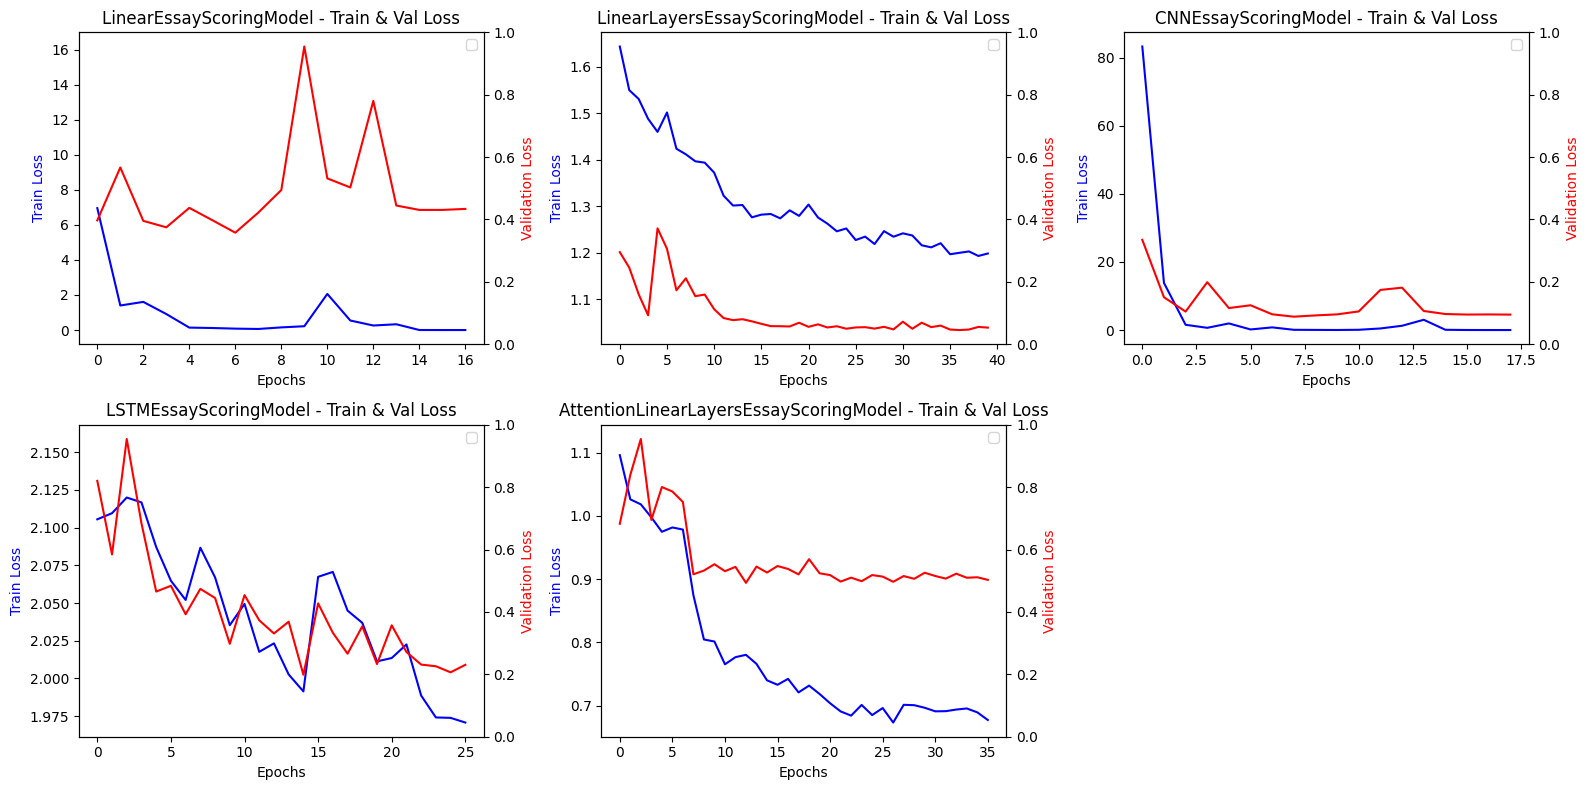

In [ ]:
plot_loss_histories(results)

**Save Neural Network Models results to a CSV file**

In [ ]:
# Saving the results to a CSV file
df_results.to_csv('df_results.csv')

# Downloading the CSV file to the local computer
files.download('df_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### <br>

### Comprehensive Model Performance Comparison Results

This section presents a consolidated table of results obtained from various experiments, including Machine Learning Models, BERT Classifier, and additional Neural Network models. The table displays the test loss, accuracy, and execution time for each model, allowing for a quick comparison of their performance.

#### Helper Functions: Table Formatting

**Apply bold formatting to the maximum and minimum values in each column**

In [ ]:
def format_min_value(val):
    return f"\033[1m{val:.4f}\033[0m"

def format_max_value(val):
    return f"\033[1m{val:.4f}\033[0m"

def bold_max_min(val, col_name, max_values, min_values):
    if col_name in ["test_loss"]:
        if val == min_values[col_name]:
            return format_min_value(val)
    elif col_name in ["test_accuracy", "execution_time (minutes)"]:
        if val == max_values[col_name]:
            return format_max_value(val)
    return f"{val:.4f}"

def format_dataframe(df):
    max_values, min_values = df_total_results.max(), df_total_results.min()
    formatted_df = pd.DataFrame()
    for col in df.columns:
        formatted_df[col] = df[col].apply(bold_max_min, args=(col, max_values, min_values))
    return formatted_df

#### Visualizing Performance: Comparing Results

In [ ]:
# Merge the models results
df_total_results = pd.concat([df_ml_results, df_bert_cls_results, df_results])

# Visualizing Performance: Comparing Results
print(tabulate(format_dataframe(df_total_results), headers='keys', tablefmt='psql', floatfmt='.4f'))

+----------------------------------------+-------------+-----------------+----------------------------+
|                                        |   test_loss |   test_accuracy |   execution_time (minutes) |
|----------------------------------------+-------------+-----------------+----------------------------|
| SVC                                    |      3.2781 |         54.0062 |                     0.7602 |
| Random Forest                          |      4.0254 |         47.6888 |                     0.8162 |
| AdaBoost                               |      8.1537 |         16.8721 |                     2.6512 |
| Logistic Regression                    |      3.3640 |         52.8891 |                     0.0322 |
| K-Nearest Neighbors                    |      5.0127 |         41.2943 |                     0.0090 |
| Decision Tree                          |      5.6325 |         34.7072 |                     0.1400 |
| Gaussian Naive Bayes                   |     12.0258 |        

**Save the results to a CSV file**

In [ ]:
# Saving the results to a CSV file
df_total_results.to_csv('essay_scoring_final_results.csv')

# Downloading the CSV file to the local computer
files.download('essay_scoring_final_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Automated Essay Scoring in the Hebrew Language

Leveraging Transfer Learning from English Language Data

Once we have identified the best English model for automated essay scoring, we proceed to perform cross-lingual transfer learning and fine-tuning for the Hebrew language. To address cross-lingual challenges, we undertake the following steps:

* **Back-translation**: We employ the `Helsinki-NLP/opus-mt-en-he` model from Hugging Face to translate English essays into Hebrew, facilitating the creation of a Hebrew dataset.
* **Hebrew Essay Embedding**: Utilizing `heBERT`, a dedicated BERT model for the Hebrew language, we convert the Hebrew essays into meaningful embeddings.
* **Training and Evaluation**: With the best-performing English model as a starting point, we fine-tune the model on the Hebrew dataset and evaluate its performance on cross-lingual automated essay scoring.

This comprehensive process enables the adaptation of the model to the nuances and characteristics of the Hebrew language, enhancing its effectiveness in scoring essays in a cross-lingual context.

**Clear the GPU memory cache**

In [ ]:
torch.cuda.empty_cache()

**Prepare Hebrew Dataset**

In [ ]:
df_essay_he = df_essay.copy()

### Back-Translation for Hebrew Dataset Creation

This section demonstrates the utilization of the `Helsinki-NLP/opus-mt-en-he` model from Hugging Face to translate English essays into Hebrew, enabling the generation of a Hebrew dataset for further analysis and research.

#### Helper Functions: Back-Translation for the Hebrew Language

**English-to-Hebrew Translator**

In [ ]:
def translate_english_to_hebrew(model, tokenizer, text):
    max_length = 512  # Maximum length that the translation model can handle

    # Split the text into chunks of maximum length
    chunks = [text[i: i + max_length] for i in range(0, len(text), max_length)]

    translated_chunks = []
    for chunk in chunks:
        # Tokenize the input chunk
        tokens = tokenizer.encode(chunk, return_tensors='pt').to(device)

        # Translate the tokens to Hebrew
        translated_tokens = model.generate(tokens, num_beams=2)
        translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

        translated_chunks.append(translated_text)

    # Concatenate the translated chunks
    translated_text = ' '.join(translated_chunks)

    return translated_text

**Hebrew Text Filter**

In [ ]:
def keep_hebrew_words(text):
    # Remove English characters
    hebrew_text = re.sub(r'[a-zA-Z]', '', text)

    # Remove extra whitespace
    hebrew_text = re.sub(r'\s+', ' ', hebrew_text)

    # Remove leading and trailing whitespace
    hebrew_text = hebrew_text.strip()

    return hebrew_text

#### Translating English Essays into Hebrew and Filtering Hebrew Text

**Load the Translation Model and Tokenizer**

In [ ]:
model_name = 'Helsinki-NLP/opus-mt-en-he'
mr_tokenizer = MarianTokenizer.from_pretrained(model_name)
mr_model = MarianMTModel.from_pretrained(model_name).to(device)

**Translate English Essays to Hebrew**

In [ ]:
# Initial Hebrew essays List
he_essays = []

# Iterate over each element in the series
for text in tqdm(df_essay_he['essay']):
    he_essay = translate_english_to_hebrew(mr_model, mr_tokenizer, text)
    he_essays.append(he_essay)

# Assign the Hebrew Translations back to the dataframe
df_essay_he['he_essay'] = he_essays

100%|██████████| 12976/12976 [5:13:25<00:00,  1.45s/it]


**Filter and clean the translated Hebrew essays, keeping only meaningful Hebrew text**

In [ ]:
df_essay_he['he_essay'] = df_essay_he['he_essay'].apply(keep_hebrew_words)

In [ ]:
df_essay_he

,essay_set,essay,score,cleaned_essay,he_essay
0,1,"Dear local newspaper, I think effects computer...",6,"dear local newspaper, i think effects computer...","העיתון המקומי היקר, אני חושב שההשפעות שיש למחש..."
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",7,"dear @caps1 @caps2, i believe that using compu...","& 1 @ 2 היקר, אני מאמין כי שימוש במחשבים יועיל..."
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",5,"dear, @caps1 @caps2 @caps3 more and more peopl...","אנשים אחרים משתמשים במחשבים יותר ויותר, אבל לא..."
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",8,"dear local newspaper, @caps1 i have found that...","עיתונים מקומיים יקרים, @1 מצאתי כי מומחים רבים..."
4,1,"Dear @LOCATION1, I know having computers has a...",6,"dear @location1, i know having computers has a...","מחשבים מחברים בין משפחות, מכילים מידע שהוא נהד..."
...,...,...,...,...,...
12971,8,In most stories mothers and daughters are eit...,5,in most stories mothers and daughters are eit...,"ברוב הסיפורים אימהות ובנות הן אויבות או חברות,..."
12972,8,I never understood the meaning laughter is th...,4,i never understood the meaning laughter is th...,מעולם לא הבנתי את המשמעות של צחוק הוא המרחק הק...
12973,8,"When you laugh, is @CAPS5 out of habit, or is ...",6,"when you laugh, is @caps5 out of habit, or is ...","כאשר אתה צוחק, האם @5 מתוך הרגל, או האם @1 סיב..."
12974,8,Trippin' on fen...,6,trippin' on fen...,"אם זה היה על משהו טיפשי שעשיתי, או החבר הכי טו..."


### Hebrew Essay Embedding with heBERT

In this section, we employ `heBERT`, a dedicated BERT model for the Hebrew language, to transform the Hebrew essays into meaningful embeddings.

**Initializes the heBERT Model and Tokenizer**

In [ ]:
model_name = 'avichr/heBERT'
he_tokenizer = AutoTokenizer.from_pretrained(model_name)

**Hebrew Text Embedding Transformation**

In [ ]:
input_ids_list = []
attentions_list = []

for text in tqdm(df_essay_he['he_essay']):
    input_ids, attentions = convert_to_input_ids_attentions(he_tokenizer, text)
    input_ids_list.append(input_ids)
    attentions_list.append(attentions)

df_essay_he['he_input_ids'] = input_ids_list
df_essay_he['he_attentions'] = attentions_list

100%|██████████| 12976/12976 [00:12<00:00, 1048.28it/s]


### Training and Evaluation: Transfer Learning from English to Hebrew

In this section, we adapt the English-trained model for Hebrew essay scoring through transfer learning and fine-tuning techniques.

#### Loading the Pretrained English Model

Description: In this step, we load the best-performing pretrained model from the English section. This model will serve as the starting point for our cross-lingual transfer learning process, providing a strong foundation for fine-tuning on the Hebrew dataset.

In [ ]:
# Initial the Hebrew Model
hebrew_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=11).to(device)

# Load the best-performing pretrained English model
en_essay_model_weights_path = 'essay_bert_cls_model_weights.pth'
print(f'{hebrew_model.__class__.__name__}: Loading model from path: {en_essay_model_weights_path}\n')
hebrew_model.load_state_dict(torch.load(en_essay_model_weights_path))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification: Loading model from path: essay_bert_cls_model_weights.pth



<All keys matched successfully>

#### Creating Custom Hebrew Dataset and DataLoaders

**Create custom Hebrew Dataloader**

In [ ]:
class HebrewEssayDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids = self.data['he_input_ids'].iloc[idx]
        attentions = self.data['he_attentions'].iloc[idx]
        score = self.data['score'].iloc[idx]
        return input_ids, attentions, score

**Split the dataset into train, validation and test sets**

In [ ]:
# Split the DataFrame into train and test sets
he_train_df, he_test_df = train_test_split(df_essay_he, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
he_train_df, he_val_df = train_test_split(he_train_df, test_size=0.2, random_state=42)

# Create train and test data loaders
he_train_dataset = HebrewEssayDataset(he_train_df)
he_val_dataset = HebrewEssayDataset(he_val_df)
he_test_dataset = HebrewEssayDataset(he_test_df)

batch_size = 64
he_train_dataloader = DataLoader(he_train_dataset, batch_size=batch_size, shuffle=True)
he_val_dataloader = DataLoader(he_val_dataset, batch_size=batch_size, shuffle=True)
he_test_dataloader = DataLoader(he_test_dataset, batch_size=batch_size, shuffle=False)

#### Initializing Model for Transfer Learning and Fine-Tuning

Description: After loading the English model, we initialize it for transfer learning by adapting it to the target language (Hebrew).

**Selecting Top Layer Parameters Function for Fine-Tuning**

In [ ]:
def get_model_parameters(model_params):
    top_layer_params = []
    for name, param in model_params:
        if 'classifier' in name or 'pooler' in name or 'encoder.layer.11' in name:
            param.requires_grad = True
            top_layer_params.append(param)
        else:
            param.requires_grad = False

    return top_layer_params

**Customizing Loss and Optimizer for Hebrew Model Fine-Tuning**

In [ ]:
# Load the saved model weights if exists
he_essay_model_weights_path = 'hebrew_essay_model_weights.pth'

if os.path.exists(he_essay_model_weights_path):
    print(f'{hebrew_model.__class__.__name__}: Loading Hebrew model from path: {he_essay_model_weights_path}\n')
    hebrew_model.load_state_dict(torch.load(he_essay_model_weights_path))
else:
    print(f'{hebrew_model.__class__.__name__}: Training from scratch...\n')

# Customizing the loss and the optimizer obejcts
hebrew_criterion = nn.CrossEntropyLoss()
hebrew_optimizer = torch.optim.AdamW(get_model_parameters(hebrew_model.named_parameters()), lr=1e-3, weight_decay=0.001)

BertForSequenceClassification: Loading Hebrew model from path: hebrew_essay_model_weights.pth



#### Running Training and Evaluation Experiment

Description: In this step, we perform the training and evaluation of the fine-tuned model on the Hebrew dataset.

**Train Hebrew BERT Classifier Model**

In [ ]:
# Clear the GPU memory cache
torch.cuda.empty_cache()

# Start measuring time
start_time = time.time()

# Train the Hebrew model
he_train_loss_history, he_val_loss_history = run(hebrew_model, he_train_dataloader, he_val_dataloader, hebrew_optimizer,
    hebrew_criterion, num_epochs=20, early_stop=True, early_stop_patience=10, save_weights_path=he_essay_model_weights_path)

end_time = time.time()                        # End measuring time
execution_time = end_time - start_time        # Compute the time for the run_experiment function
execution_time_minutes = execution_time / 60  # Convert time to minutes

Epoch [1/20]: Train Loss: 1.4230, Train Accuracy: 43.68%, Val Loss: 1.4210, Val Accuracy: 42.63%
[Loss] Saving model to path: hebrew_essay_model_weights.pth
[Accuracy] Saving model to path: hebrew_essay_model_weights.pth
Epoch [2/20]: Train Loss: 1.3944, Train Accuracy: 44.61%, Val Loss: 1.5224, Val Accuracy: 41.28%
Epoch [3/20]: Train Loss: 1.3997, Train Accuracy: 44.08%, Val Loss: 1.4541, Val Accuracy: 41.47%
Epoch [4/20]: Train Loss: 1.3943, Train Accuracy: 44.53%, Val Loss: 1.4382, Val Accuracy: 40.46%
Epoch [5/20]: Train Loss: 1.3693, Train Accuracy: 45.23%, Val Loss: 1.4556, Val Accuracy: 40.94%
Epoch [6/20]: Train Loss: 1.3618, Train Accuracy: 45.82%, Val Loss: 1.4443, Val Accuracy: 42.20%
Epoch [7/20]: Train Loss: 1.3639, Train Accuracy: 45.66%, Val Loss: 1.4304, Val Accuracy: 43.69%
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
[Accuracy] Saving model to path: hebrew_essay_model_weights.pth
Epoch [8/20]: Train Loss: 1.2905, Train Accuracy: 47.94%, Val Loss: 1.3

**Evaluate Hebrew BERT Classifier Model**

In [ ]:
hebrew_model.load_state_dict(torch.load(he_essay_model_weights_path))
he_test_loss, he_test_accuracy = evaluate(hebrew_model, he_test_dataloader, hebrew_criterion, print_classification_report=True)
print(f'Test Loss: {he_test_loss:.4f}, Accuracy: {he_test_accuracy:.2f}%')


               precision    recall  f1-score   support

           0       0.40      0.16      0.23       104
           2       0.33      0.32      0.32       123
           3       0.55      0.56      0.56       279
           4       0.60      0.52      0.56       241
           5       0.41      0.39      0.40       336
           6       0.46      0.72      0.56       400
           7       0.43      0.42      0.43       370
           8       0.48      0.54      0.51       403
           9       0.00      0.00      0.00        55
          10       0.54      0.35      0.43       285

    accuracy                           0.47      2596
   macro avg       0.42      0.40      0.40      2596
weighted avg       0.47      0.47      0.46      2596

Test Loss: 1.3204, Accuracy: 47.42%


#### Running Evaluation for Scores Accuracy Range

Description: This section focuses on categorizing predicted essay scores and analyzing the accuracy of those predictions within different score ranges.

Scores Ranges:
- **Below Average**: scores from 0 to 3.
- **Average**: scores from 4 to 7.
- **Above Average**: scores from 8 to 10.

##### Compute Scores Accuracy Range Functions

In [ ]:
def evaluate_predictions(model, dataloader, criterion):
    y_test = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for input_ids, attentions, scores in dataloader:
            input_ids = input_ids.to(device)
            attentions = attentions.to(device)
            scores = scores.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attentions)
            logits = outputs.logits
            loss = criterion(logits, scores)

            _, predicted = torch.max(logits.data, 1)

            y_test.extend(scores.tolist())
            y_pred.extend(predicted.tolist())

    return y_test, y_pred

def calculate_range_accuracy(y_test, y_pred):
    below_average_count = 0
    average_count = 0
    above_average_count = 0

    total_below_average_count = 0
    total_average_count = 0
    total_above_average_count = 0

    for actual, predicted in zip(y_test, y_pred):
        if 0 <= predicted <= 3:
            total_below_average_count += 1
            if 0 <= actual <= 3:
                below_average_count += 1
        elif 4 <= predicted <= 7:
            total_average_count += 1
            if 4 <= actual <= 7:
                average_count += 1
        elif 8 <= predicted <= 10:
            total_above_average_count += 1
            if 8 <= actual <= 10:
                above_average_count += 1

    total_correct = below_average_count + average_count + above_average_count
    accuracy = total_correct / len(y_test)

    below_average_accuracy = below_average_count / total_below_average_count if total_below_average_count > 0 else 0
    average_accuracy = average_count / total_average_count if total_average_count > 0 else 0
    above_average_accuracy = above_average_count / total_above_average_count if total_above_average_count > 0 else 0

    return accuracy, below_average_accuracy, average_accuracy, above_average_accuracy

def print_acc_range_results(accuracy, below_average_accuracy, average_accuracy, above_average_accuracy):
    print(f"Total Accuracy Range   [All] : {accuracy:.2%}\n{'-'*37}")
    print(f"Below Average Accuracy [0-3] : {below_average_accuracy:.2%}")
    print(f"Average Accuracy       [4-7] : {average_accuracy:.2%}")
    print(f"Above Average Accuracy [8-10]: {above_average_accuracy:.2%}")

##### Compute Scores Accuracy Range

In [ ]:
hebrew_model.load_state_dict(torch.load(he_essay_model_weights_path))
y_test, y_pred = evaluate_predictions(hebrew_model, he_test_dataloader, hebrew_criterion)
accuracy, below_average_accuracy, average_accuracy, above_average_accuracy = calculate_range_accuracy(y_test, y_pred)

**Displaying Accuracy Range Results**

In [ ]:
accuracy_range_results = {
    'Range': ['Total Accuracy [All]', 'Below Average [0-3]', 'Average [4-7]', 'Above Average [8-10]'],
    'Test Accuracy Range': [accuracy, below_average_accuracy, average_accuracy, above_average_accuracy]
}

df_accuracy_range_results = pd.DataFrame(accuracy_range_results)
df_accuracy_range_results['Test Accuracy Range'] = df_accuracy_range_results['Test Accuracy Range'] * 100
print(tabulate(df_accuracy_range_results, headers='keys', tablefmt='psql', floatfmt='.4f', showindex=False))

+----------------------+-----------------------+
| Range                |   Test Accuracy Range |
|----------------------+-----------------------|
| Total Accuracy [All] |               71.0324 |
| Below Average [0-3]  |               69.5946 |
| Average [4-7]        |               70.9742 |
| Above Average [8-10] |               72.1617 |
+----------------------+-----------------------+


**Save Accuracy Range Model results to a CSV file**

In [ ]:
# Saving the results to a CSV file
df_accuracy_range_results.to_csv('df_accuracy_range_results.csv')

# Downloading the CSV file to the local computer
files.download('df_accuracy_range_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Visualizing Cross-Lingual Scoring Results

Description: Once the training and evaluation are completed, we plot the results to gain insights into the model's performance in cross-lingual automated essay scoring.

**Displaying Results for Hebrew Essay Scoring Model**

In [ ]:
he_results = {}

# Store model results
he_model_results = {
    'test_loss': he_test_loss,
    'test_accuracy': he_test_accuracy,
    'execution_time (minutes)': execution_time_minutes
}

he_results['HebrewEssayScoringModel'] = he_model_results

df_he_results = pd.DataFrame.from_dict(he_results, orient='index')
print(tabulate(df_he_results, headers='keys', tablefmt='psql', floatfmt='.4f'))

+-------------------------+-------------+-----------------+----------------------------+
|                         |   test_loss |   test_accuracy |   execution_time (minutes) |
|-------------------------+-------------+-----------------+----------------------------|
| HebrewEssayScoringModel |      1.3204 |         47.4191 |                   127.6798 |
+-------------------------+-------------+-----------------+----------------------------+


**Plotting Loss History for Hebrew Essay Scoring Model**

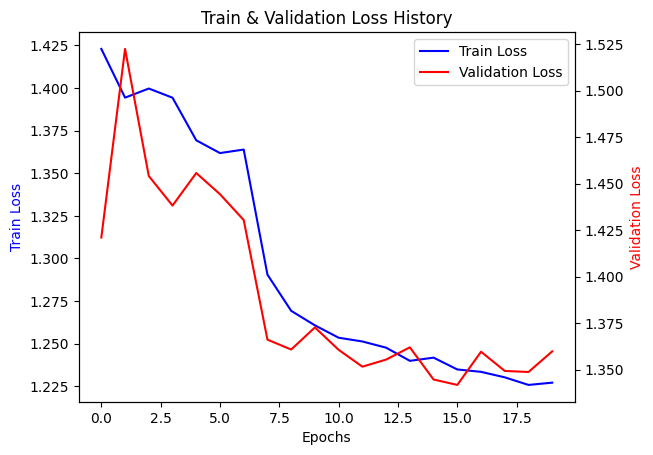

In [ ]:
plot_loss_history(he_train_loss_history, he_val_loss_history)

**Save Hebrew Model results to a CSV file**

In [ ]:
# Saving the results to a CSV file
df_he_results.to_csv('df_he_results.csv')

# Downloading the CSV file to the local computer
files.download('df_he_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## <br>

## Automated Essay Scoring Prediction

In this section, after completing the training phase, we will evaluate the performance of our best Cross-Lingual Automated Essay Scoring model. We will perform multiple predictions on example essays using our model to assess how well they can score the essays. This evaluation will provide insights into the model's effectiveness in automated essay scoring for both English and Hebrew languages.

\
**Note:** In this section, you may perform predictions using the automated essay scoring model **without the need to run the entire notebook.**

### Setup Preparation for Essay Scoring Predictions

Follow these steps to predict essay scores using the pre-trained model without running the entire notebook:
1. **Upload Model Weights:**
  * Download the pre-trained model weights as "*essay_model_weights.pth*" using this [link](https://drive.google.com/file/d/1nV_CuqiJSHJIlCbxYHQqkO05m5kySzjf/view?usp=sharing).
  * Upload the "*essay_model_weights.pth*" file to your Google Drive under a folder named "*essay-model*". If this folder doesn't exist, create it.
2. **Mount Your Colab Notebook:**
  * Run the following cell below under the "*Mount Your Colab Notebook*" section to mount your Google Drive and grant the necessary permissions.
3. **Copy Model Weights to Local Notebook:**
  * Copy the model weights from your Google Drive to the Colab local directory using the "*Copy Model Weights*" section.
4. **Setup Preparation for Essay Scoring Predictions:**
  * Execute the cell under the "*Setup Preparation*" section.

\
Once the setup is complete, you are ready to make predictions on your essays!

**Mount Your Colab Notebook**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Copy Model Weights**

In [2]:
!cp /content/gdrive/MyDrive/essay-model/essay_model_weights.pth /content/essay_model_weights.pth

**Setup Preparation**

In [3]:
!pip install -q transformers contractions

import math
import re
import contractions
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from transformers import BertModel, BertTokenizer
from transformers import BertForSequenceClassification
import warnings

warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

def clean_text(text):
    text = expand_contractions(text)
    text = text.lower()
    return text

def convert_to_input_ids_attentions(tokenizer, text):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=512,
        truncation=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].squeeze().cpu().numpy()
    attentions = inputs['attention_mask'].squeeze().cpu().numpy()

    return input_ids, attentions

model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_name)

model_name = 'avichr/heBERT'
he_tokenizer = AutoTokenizer.from_pretrained(model_name)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.9 MB/s eta 0:00:00


### Essay Scoring Model Loading and Initialization

In [4]:
essay_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=11).to(device)
essay_model.load_state_dict(torch.load('essay_model_weights.pth'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

### Essay Scoring Prediction

#### Automated Essay Scoring Prediction Functions

In [5]:
# Function to preprocess a single essay for prediction
def preprocess_essay_for_prediction(essay, embeddings_tokenizer, language):
    if language == 'en':
        essay = clean_text(essay)
    input_ids, attetion_mask = convert_to_input_ids_attentions(embeddings_tokenizer, essay)
    return torch.tensor(input_ids).to(device), torch.tensor(attetion_mask).to(device)

def predict(essay_model, embeddings_tokenizer, essay, prediction, language='en'):
    # Preprocess the essay and make the prediction
    input_ids, attention_mask = preprocess_essay_for_prediction(essay, embeddings_tokenizer, language)

    # Add a batch dimension
    input_ids = input_ids.unsqueeze(0)
    attention_mask = attention_mask.unsqueeze(0)

    essay_model.eval()
    with torch.no_grad():
        output = essay_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = output.logits
        _, predicted_score = torch.max(logits.data, 1)

    # Print the predicted score
    print(f'Expected Score: {prediction}\nPredicted Score: {predicted_score.item()}\n')

#### Scoring Prediction for an Example English Essay

In [6]:
# @title High-Quality Essay Example

essay = 'Technology, the catalyst of our era, has irreversibly reshaped our world, permeating every sphere of human existence. Its impact is undeniable, revolutionizing communication, revolutionizing work processes, and revolutionizing entertainment. Through the internet and social media, technology has bridged vast distances, connecting people across continents and cultures, fostering a sense of global community. It has unleashed unprecedented levels of productivity, enabling us to accomplish tasks with efficiency and precision. In the field of healthcare, technology has empowered medical professionals with advanced diagnostic tools, cutting-edge treatments, and telemedicine, saving lives and improving patient outcomes. Moreover, technology has sparked an era of unparalleled innovation, propelling us into uncharted territories and opening doors to limitless possibilities. It has given birth to transformative inventions such as artificial intelligence, blockchain, and virtual reality, revolutionizing industries and challenging our perception of what is achievable. However, as we embrace the benefits of technology, we must also grapple with its ethical implications. Issues of privacy, cybersecurity, and the growing digital divide demand our attention and proactive solutions. Ultimately, the responsible and conscientious integration of technology into our lives will determine the path we tread, shaping a future where progress coexists harmoniously with human values and well-being.' # @param {type:"string"}

predict(essay_model, bert_tokenizer, essay, 10)

Expected Score: 10
Predicted Score: 10



In [7]:
# @title Average Essay Example

essay = "Technology is present all around us in today's world. People are frequently engaged with their devices, such as smartphones and computers, for various tasks. While these technologies have made communication more convenient through platforms like social media, they have also led to reduced face-to-face interactions. Medical advancements have been notable, with machines even being used for complex surgeries, offering both benefits and concerns. On the downside, there's an ongoing debate about technology causing job displacement as automation becomes more prevalent. Additionally, the digital age has raised concerns about privacy due to the collection and sharing of personal data on the internet. In conclusion, technology is a double-edged sword, offering advantages and disadvantages that necessitate a thoughtful approach to its integration into our lives." # @param {type:"string"}

predict(essay_model, bert_tokenizer, essay, 5)

Expected Score: 5
Predicted Score: 5



In [8]:
# @title Below-Average Essay Example

essay = "Uh, so, technology, right? It's like, totally awesome, dude! Like, seriously, it's the best thing that has ever happened to humanity. We can, like, do so many cool things with it. We can, um, watch cat videos all day long and, uh, post selfies on social media, like, every five minutes. It's, like, the ultimate time-waster, man. And let's not forget about all those amazing online shopping sites. We can, like, buy anything we want without even leaving our couch. It's, like, a shopaholic's dream come true." # @param {type:"string"}

predict(essay_model, bert_tokenizer, essay, 0)

Expected Score: 0
Predicted Score: 0



#### Scoring Prediction for an Example Hebrew Essay

In [9]:
# @title High-Quality Essay Example

essay = "הטכנולוגיה היא חלק בלתי נפרד מחיינו היום, והיא משפיעה על כל תחומי החיים שלנו, כולל הלימוד באקדמיה. הטכנולוגיה מציעה מגוון רחב של יתרונות לסטודנטים, כגון גישה למידע רב, אפשרויות למידה אינטראקטיביות, ושיתוף פעולה עם סטודנטים אחרים מרחבי העולם.  אחד היתרונות הגדולים של הטכנולוגיה הוא שהיא מאפשרת לסטודנטים לגשת למידע רב מהאינטרנט. בעבר, סטודנטים היו צריכים ללכת לספרייה כדי למצוא מידע, אך כיום הם יכולים למצוא מידע על כל נושא בלחיצת כפתור. זה מקל מאוד על סטודנטים לחקור נושאים לפרויקטים ולעבודות, וזה גם מאפשר להם להישאר מעודכנים על החדשות בתחומי העניין שלהם.  טכנולוגיה גם מאפשרת לסטודנטים ללמוד בצורה אינטראקטיבית יותר. בעבר, סטודנטים למדו בעיקר באמצעות הרצאות, אך כיום ישנם מגוון רחב של אפשרויות למידה אינטראקטיביות, כגון קורסים מקוונים, תוכנות סימולציה, ופורומים דיונים. אפשרויות למידה אינטראקטיביות אלו מאפשרות לסטודנטים ללמידה יעילה יותר, וזה גם מקל עליהם להבין את החומר הנלמד.  טכנולוגיה גם מאפשרת לסטודנטים לשתף פעולה עם סטודנטים אחרים מרחבי העולם. בעבר, סטודנטים יכלו לתקשר רק עם סטודנטים ששהו באותו קמפוס, אך כיום הם יכולים לתקשר עם סטודנטים מכל העולם באמצעות האינטרנט. זה מאפשר לסטודנטים ללמוד מאנשים עם תרבויות ורקעים שונים, וזה גם מקל עליהם לבנות קשרים עם סטודנטים אחרים.  בסך הכל, הטכנולוגיה מציעה מגוון רחב של יתרונות לסטודנטים. היא מאפשרת להם לגשת למידע רב, ללמוד בצורה אינטראקטיבית יותר, ושיתוף פעולה עם סטודנטים אחרים מרחבי העולם. הטכנולוגיה היא כלי רב עוצמה שיכול לשפר את איכות ההשכלה של הסטודנטים.  עם זאת, חשוב להשתמש בטכנולוגיה באחריות. שימוש רב מדי בטכנולוגיה יכול להוביל לבעיות כגון התמכרות, עייפות, וירידה בפרודוקטיביות. חשוב לקבוע הגבלות על השימוש בטכנולוגיה, ולהשתמש בה בצורה בריאה ומועילה.  טכנולוגיה היא כלי רב עוצמה שיכול לשפר את איכות ההשכלה שלנו. חשוב להשתמש בטכנולוגיה באחריות, ולהפיק ממנה את המרב." # @param {type:"string"}

predict(essay_model, he_tokenizer, essay, 10, language='he')

Expected Score: 10
Predicted Score: 8



In [10]:
# @title Average Essay Example

essay = "טכנולוגיה היא חלק בלתי נפרד מחיינו היום. היא משפיעה על כל תחומי החיים שלנו, החל מעבודה ועד בידור. הטכנולוגיה מציעה לנו מגוון רחב של יתרונות, אך יש לה גם כמה חסרונות.  אחד היתרונות הגדולים של הטכנולוגיה הוא שהיא מאפשרת לנו לתקשר עם אנשים מכל העולם. אנחנו יכולים להשתמש באינטרנט כדי לדבר עם חברים ובני משפחה שנמצאים רחוק, ואנחנו יכולים גם להכיר אנשים חדשים מכל התרבויות. הטכנולוגיה גם מאפשרת לנו לקבל מידע מהיר ועדכני על כל נושא. אנחנו יכולים להשתמש באינטרנט כדי ללמוד על נושאים חדשים, ואנחנו יכולים גם להישאר מעודכנים על החדשות בעולם.  טכנולוגיה גם מאפשרת לנו להיות יעילים יותר בעבודה. אנחנו יכולים להשתמש במחשבים כדי לגשת למידע, כדי לעבד מסמכים, ולעבד משימות. הטכנולוגיה גם מאפשרת לנו לעבוד מהבית, מה שמאפשר לנו לחסוך זמן וכסף.  עם זאת, יש גם כמה חסרונות לטכנולוגיה. אחד החסרונות הגדולים הוא שהיא יכולה להיות ממכרת. אנחנו יכולים להתמכר לשימוש במחשבים, בטלפונים ובמכשירים אלקטרוניים אחרים. התמכרות לטכנולוגיה יכולה לגרום לבעיות בריאותיות, כגון בעיות שינה, השמנה, וחרדה.  חיסרון נוסף של הטכנולוגיה הוא שהיא יכולה לגרום לנו להיות מבודדים חברתית. אנחנו יכולים להעדיף להתחבר עם אנשים באינטרנט מאשר להתקשר עם אנשים בחיים האמיתיים. זה יכול להוביל לבעיות ביצירת קשרים חברתיים, וזה יכול גם להוביל לדיכאון.  בסך הכל, הטכנולוגיה היא כלי רב עוצמה שיש לו יתרונות וחסרונות. חשוב להשתמש בטכנולוגיה באחריות, ולהיות מודעים לסיכונים והיתרונות שלה." # @param {type:"string"}

predict(essay_model, he_tokenizer, essay, 5, language='he')

Expected Score: 5
Predicted Score: 6



In [11]:
# @title Below-Average Essay Example

essay = " טכנולוגיה היא דבר טוב סך הקול. זה מאפשר לנו לעשות דברים שאי אפשר היה לעשות לפני כן. זה עוזר לנו ללמוד, לעבוד וליהנות, אבל יש גם כמה חסרונות לטכנולוגיה, זה יכול להיות ממכר, זה יכול לגרום לנו להיות מבודדים, וזה יכול להיות מסוכן." # @param {type:"string"}

predict(essay_model, he_tokenizer, essay, 0, language='he')

Expected Score: 0
Predicted Score: 2

